# Snowball bifurcation energy balance model

This notebook implements the 0-D energy balance model of Pierrehumbert et al. (2011). 
It utilizes the Python script published by Pierrehumbert et al. (2011) which itself uses the ClimateUtilities modules.

This is the text that Pierrehumbert et al. (2011) wrote regarding the modules that are imported in the code cell below:
```
#-----Import needed libararies---
#The following two libraries are distributed free as
#part of the courseware supplement for Principles of Planetary Climate.
#They can be downloaded from
#   http://geosci.uchicago.edu/~rtp1/PrinciplesPlanetaryClimate/Courseware/coursewarePortal.html
#The module ClimateUtilities needs the module ClimateGraphics.py, if you
#intend to install Ngl graphics and do your graphics within Python, or
#DummyGraphics.py if you plan to dump the results to a text file and
#plot it using some other graphics package.
#
```

With this additional description regarding ```OLRPoly```:

```
#The following is a specialized form of the polynomial fit
#to OLR vs surface temperature and CO2, including the effects
#of pressure broadening.  It is distributed as part of the
#supplementary material on the AREPS site
```

In [1]:
from ClimateUtilities import *
import phys
import OLRPoly

Version for debugging readTable
Using Sandbox version of ClimateGraphicsMPL
Using MatPlotLib graphics


## Generating ice-albedo bifurcation visualization using EBM

The code cell below is the script published by Pierrehumbert et al. 2011 that generates the results of their Figure 3. 

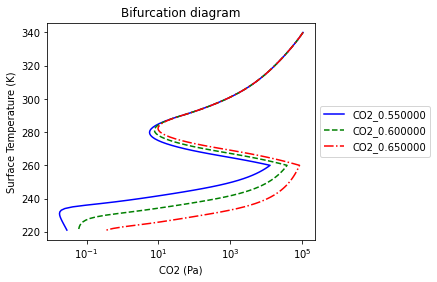

In [2]:
#--------------------------------------------------------------
#
# This Python script was used to do the computations that
# went into the basic ice-albedo bifurcation diagram in
# Figure 3 .
#--------------------------------------------------------------
#Note that the graph in Figure 3 has been fancied up using Adobe
#illustrator. The software below just produces the basic set of
#curves that are the basis of the graph. It does not automatically
#mark the unstable branch with dashed lines, as has been done
#in Figure 3. This code could be easily modified to do that, but
#that feature has been left out in order to keep the code simpler
#and easier to understand. 

#Define albedo and OLR functions here
#Radiating pressure pRad, in mb, is a global
#Note that the CO2 inventory is not the conventional
#CO2 concentration, but instead the CO2 inventory (in Pa)
#defined in the article.  The pressure broadening is
#computed on the basis of 1 bar (1.e5 Pa) of non-CO2 dry
#air. The effect of water vapor with 50% relative humidity
#is included.
def OLR(T,CO2):
    return OLRPoly.OLRT(CO2,T)

#Write Newton solver to get T(CO2)
def fOLR(CO2,params):
    return OLRPoly.OLRT(CO2,params.T) - params.flux
m = newtSolve(fOLR)
params = Dummy()
m.setParams(params)

#Parameters of albedo function are globals
def albedo(T):
    if T < T1:
        return alpha_ice
    elif (T >= T1)&(T<=T2):
        r = (T-T2)**2/(T2-T1)**2
        return alpha_0 + (alpha_ice - alpha_0)*r
    else:
        return alpha_0

def BifurcCO2(Tlist,L,cloud=0.):
    CO2L = 100.
    SabsList = []
    CO2List = []
    OLRlist = []
    NetFluxlist = []
    Glist = []

    for T in Tlist:
        params.flux = (1.-albedo(T))*L/4. + cloud
        params.T = T
        try:
            CO2L = m(CO2L)
            slask = 1.*CO2L
            CO2List.append(CO2L)
        except:
            CO2List.append(1.e-5)
            CO2L = 1000.
    return CO2List

#Utilitity for finding left and right limits of
#hysteresis loop. V is the  list of values of the
#control parameter corresoponding to the list of
#temperatures in ascending order. Typically V
#would contain CO2 concentrations or inventories
def TurningPoints(V):
    results = []
    for i in range(3,len(V)-3):
        if (V[i-3]-V[i])*(V[i]-V[i+3]) < 0.:
            results.append(V[i])
    return results

#=========Function Definitions Done============================
#              Main body of script starts here
#==============================================================

#Set up a list of temperature values for the bifurcation plot
Tlist = [340.-i  for i in range(340-220)]

#Set up a Curve() object to contain the results. The
#results consist of a set of columns of the CO2 values
#that correspond to each temperature, including ice-albedo
#feedback
c = Curve()
c.addCurve(Tlist,'Ts')
#Plotting options. (ignored if you aren't using
#the plot function in ClimateUtilities, and are
#instead just dumping the results to a text file)
c.switchXY = True #Switches axis so it looks like a hysteresis plot
c.PlotTitle = 'Bifurcation diagram'
c.Xlabel = 'Surface Temperature (K)'
c.Ylabel = 'CO2 (Pa)'
c.XlogAxis = True

#Now loop over the parameters you wish to vary, and
#add a curve to the bifurcation diagram for each parameter
#set. This loop is set up to vary the ice albedo, but you
#can instead loop over anything else you want to explore
for alpha_ice in [.55,.6,.65]:
    L = .94*1367. #Neoproterozoic value of solar constant
    #alpha_ice = .6 # Ice albedo.
                    #Set value here if you are looping over something else
    alpha_0 = .2 #Ocean albedo
    T1 = 260.    #Temperature at which planet is ice-covered
    T2 = 290.    #Temperature at which planet is ice-free
    cloudOffset = 20. #Cloud longwave forcing (W/m**2)
    #Now calculate the list of CO2 corresponding to the temperatures
    CO2List = BifurcCO2(Tlist,L,cloudOffset)
    #Put results in the Curve. The second argument makes a column
    #header tagged with the value of the parameter you are varying
    c.addCurve(CO2List,'CO2_%f'%alpha_ice) 

#Note that the portions of the diagram where the CO2 goes
#below 1 Pa are unphysical, since the OLR fits are not valid
#at such low values.  These were masked out in Figure 3 in
#the article
    
#Plot results, or dump to text file
#Uncomment the following two lines to plot
#the results and save the plot to postscript
#w = plot(c)
#w.save('SnowballBifurcation')
#
#Dump the results to a text file for plotting
c.dump('code_output/SnowballBifurcationData.txt')

plot(c)

## Import additional scientific Python modules in order to visualize EBM results

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
import numpy as np

## Set model parameters

In [4]:
Tlist = np.arange(340, 210, -0.1)

L = .94*1367. #Neoproterozoic value of solar constant
alpha_ice = .7
alpha_0 = .235 #Surface + low clouds albedo (Ray thinks about it as water world with clouds)
T1 = 260.    #Temperature at which planet is ice-covered
T2 = 290.    #Temperature at which planet is ice-free
cloudOffset = 25. #Cloud longwave forcing (W/m**2)
#Now calculate the list of CO2 corresponding to the temperatures
CO2List = BifurcCO2(Tlist,L,cloudOffset)

CO2List_ppm = [value * 6.6 for value in CO2List]
Tlist_c = [value - 273 for value in Tlist]

In [5]:
turning_points = TurningPoints(CO2List_ppm)
turning_points

[202.58954246949878,
 202.53116577199566,
 202.5799590485277,
 881895.6428681437,
 878967.5039163041,
 876036.5536559173]

In [6]:
results_dict = {'CO2':CO2List_ppm,'temp':Tlist_c}
results_df = pd.DataFrame(results_dict)
results_df

,CO2,temp
0,797856.260411,67.0
1,792538.398320,66.9
2,787241.847316,66.8
3,781966.671394,66.7
4,776712.933113,66.6
...,...,...
1295,2.044440,-62.5
1296,2.028999,-62.6
1297,2.014146,-62.7
1298,1.999857,-62.8


## Plot model results

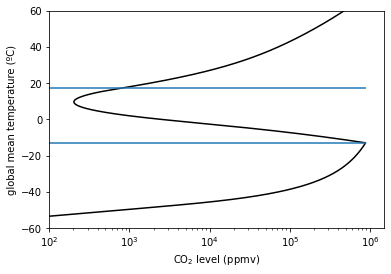

In [7]:
plt.plot(CO2List_ppm,Tlist_c,color='k')
plt.hlines(T1-273,min(CO2List_ppm),max(CO2List_ppm))
plt.hlines(T2-273,min(CO2List_ppm),max(CO2List_ppm))
plt.xscale('log')
plt.ylabel('global mean temperature (ºC)')
plt.xlabel('CO$_2$ level (ppmv)')
plt.xlim(100,1500000)
plt.ylim(-60,60)
plt.savefig('code_output/SnowballBifurcation.svg')

## Modify model results plot

Here we make a simplified plot of just the upper and lower limb without showing the unstable branches. In addition, CO$_2$ decrease scenarios are shown (2 CO$_2$ halvings) starting at different initial global mean temperatures.

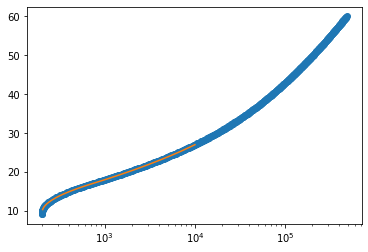

In [8]:
results_upper_limb = results_df[(results_df['temp'] > 9) & (results_df['temp'] < 60)]
results_lower_limb = results_df[(results_df['temp'] < T1-273) & (results_df['CO2'] > turning_points[0])]

f = interpolate.interp1d(results_upper_limb['CO2'], results_upper_limb['temp'])
CO2_interpolate = np.arange(205, 10000, 1)
T_interpolate = f(CO2_interpolate)   # use interpolation function returned by `interp1d`
plt.plot(results_upper_limb['CO2'], results_upper_limb['temp'], 'o', CO2_interpolate, T_interpolate, '-')
plt.xscale('log')
plt.show()

In [9]:
snowball_onset_CO2 = 205
snowball_onset_T = f(snowball_onset_CO2)
pre_snowball_onset_CO2 = snowball_onset_CO2 * 2 * 2
pre_snowball_onset_T = f(pre_snowball_onset_CO2)

cooling_CO2 = 1800
cooling_T = f(cooling_CO2)
pre_cooling_CO2 = cooling_CO2 * 2 * 2
pre_cooling_T = f(pre_cooling_CO2)


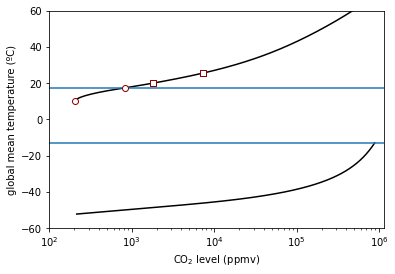

In [10]:
plt.plot(results_upper_limb['CO2'], results_upper_limb['temp'],color='k')
plt.plot(results_lower_limb['CO2'], results_lower_limb['temp'],color='k')
plt.hlines(T1-273,min(CO2List_ppm),max(CO2List_ppm)*1.3)
plt.hlines(T2-273,min(CO2List_ppm),max(CO2List_ppm)*1.3)
plt.scatter(snowball_onset_CO2,snowball_onset_T,
            edgecolor='darkred',facecolor='white',marker='o',zorder=100)
plt.scatter(pre_snowball_onset_CO2,pre_snowball_onset_T,
            edgecolor='darkred',facecolor='white',marker='o',zorder=100)
plt.scatter(cooling_CO2,cooling_T,
            edgecolor='darkred',facecolor='white',marker='s',zorder=100)
plt.scatter(pre_cooling_CO2,pre_cooling_T,
            edgecolor='darkred',facecolor='white',marker='s',zorder=100)
plt.xscale('log')
plt.ylabel('global mean temperature (ºC)')
plt.xlabel('CO$_2$ level (ppmv)')
plt.xlim(100,max(CO2List_ppm)*1.3)
plt.ylim(-60,60)
plt.savefig('code_output/SnowballBifurcation_w_decline.svg')